**CSI5139 Assignment 1: Image Labelling - Linear Classiﬁcation**

In this assignment we use the CMU Image dataset, and train binary and multiclass linear classifier.

# Setup

In [1]:
import pgm2pil
import PIL.Image
import numpy as np
import os
from scipy import misc
from pprint import pprint
import imageio
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

# models
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from skimage.filters import roberts, sobel, prewitt

origImageOpen = PIL.Image.open
PIL.Image.open = pgm2pil.imageOpenWrapper

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

# CMU Image dataset

In [3]:
def appendArray(images, labels, image, label):
    label = np.array([label])
    image = image.reshape(1, -1)
    if images is None:
        images = image
        labels = label
    else:
        images = np.r_[images, image]
        labels = np.r_[labels, label]
    
    return [images, labels]

In [4]:
folder = 'datasets/faces/'
folders = [x[0] for x in os.walk(folder)]
folders = folders[1:]

A1, A2, A4 = None, None, None
Y1, Y2, Y4 = None, None, None
for fld in folders:
    for file in os.listdir(fld):
        labels = file
        file = os.path.join(fld, file)
        
        # handle .bad files
        if file.endswith('.pgm'):

            image = PIL.Image.open(file)
            image = np.array(image)
            
            # get target person, head pose, facial expression, sunglasses state
            labels = labels.split('.')
            labels = labels[0].split('_')

            # sort resolution
            if len(labels) == 4:
                A1, Y1 = appendArray(A1, Y1, image, labels)
            elif len(labels) == 5:
                res = labels[-1]
                labels = labels[:-1]
                if res == '2':
                    A2, Y2 = appendArray(A2, Y2, image, labels)
                elif res == '4':
                    A4, Y4 = appendArray(A4, Y4, image, labels)     

pprint(A1)
pprint(Y1)
print("# A1: ", len(A1))
print("# A1[0]: ", len(A1[0]))
print("# Y1: ", len(Y1))
print("# A2: ", len(A2))
print("# A2[0]: ", len(A2[0]))
print("# Y2: ", len(Y2))
print("# A4: ", len(A4))
print("# A4[0]: ", len(A4[0]))
print("# Y4: ", len(Y4))

array([[34.326923 ,  3.2692308,  1.6346154, ..., 80.09615  , 40.865383 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  3.227848 ,  0.       ,
         0.       ],
       [34.326923 ,  3.2692308,  0.       , ...,  6.5384617,  1.6346154,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  7.0833335, ..., 69.0625   , 69.0625   ,
        67.291664 ],
       [ 0.       ,  0.       ,  7.2340426, ..., 68.723404 , 66.914894 ,
        65.106384 ],
       [ 0.       ,  0.       ,  8.916084 , ..., 71.328674 , 69.545456 ,
        67.76224  ]], dtype=float32)
array([['an2i', 'left', 'angry', 'open'],
       ['an2i', 'left', 'angry', 'sunglasses'],
       ['an2i', 'left', 'happy', 'open'],
       ...,
       ['tammo', 'up', 'neutral', 'sunglasses'],
       ['tammo', 'up', 'sad', 'open'],
       ['tammo', 'up', 'sad', 'sunglasses']], dtype='<U10')
# A1:  624
# A1[0]:  15360
# Y1:  624
# A2:  624
# A2[0]:  3840
# Y2:  624
# A4:  624
# A4[0]:  960
# Y4:  624


Use the matplotlib library to plot the image as a grayscale image with pyplot. Find images labeled sunglasses of different resolutions.   

There are 311 images that are labeled sunglasses


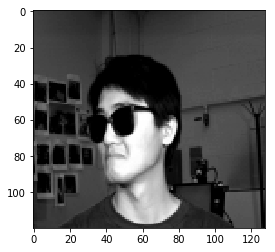

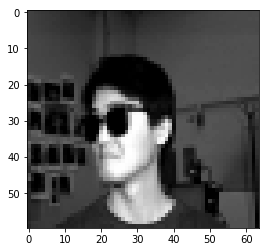

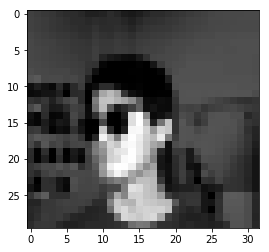

In [5]:
indexSung = np.where(Y1=='sunglasses')[0]
print('There are {0} images that are labeled sunglasses'.format(indexSung.shape[0]))

# randomly pick an image
np.random.seed(42)
pick = indexSung[np.random.choice(indexSung.shape[0])]
sung1, sung2, sung4 = A1[pick,:], A2[pick,:], A4[pick,:]
# reshape into a matrix
sung1_image, sung2_image, sung4_image = sung1.reshape(120, 128), sung2.reshape(60, 64), sung4.reshape(30, 32)
plt.ion() 
plt.imshow(sung1_image, cmap=plt.cm.gray)
plt.show()
plt.imshow(sung2_image, cmap=plt.cm.gray)
plt.show()
plt.imshow(sung4_image, cmap=plt.cm.gray)
plt.show()

# Test and Training Data

Split data into test and training data after re-shuffling the data. Split into 80/20 splits, ie 500/124 given 624 data instances.

In [6]:
np.random.seed(42)
shuffle_index = np.random.permutation(624)
print(shuffle_index[0])
# reshuffle the data and use 500 samples as training and 124 as test
A1train, A1test, Y1train, Y1test = A1[shuffle_index[:500],:], A1[shuffle_index[500:],:], Y1[shuffle_index[:500]], Y1[shuffle_index[500:]]
A2train, A2test, Y2train, Y2test = A2[shuffle_index[:500],:], A2[shuffle_index[500:],:], Y2[shuffle_index[:500]], Y2[shuffle_index[500:]]
A4train, A4test, Y4train, Y4test = A4[shuffle_index[:500],:], A4[shuffle_index[500:],:], Y4[shuffle_index[:500]], Y4[shuffle_index[500:]]

446


# Binary Classifier
Use A4 to train a logistic regression classiﬁer for the class sunglasses vs. open. Find and print the confusion matrix, the accuracy, the recall and the precision of your classiﬁer based on the training data, as well as on the testing data. Print the ROC curve.

In [7]:
Y4train_sung = (Y4train == 'sunglasses')[:,3]
Y4test_sung = (Y4test == 'sunglasses')[:,3]

print('We have a training set with {0} images of sunglasses, and a test set with {1}'.format(sum(Y4train_sung),sum(Y4test_sung)))


We have a training set with 248 images of sunglasses, and a test set with 63


In [8]:
bin_clf = LogisticRegression(max_iter=50, verbose=True)
bin_clf.fit(A4train, Y4train_sung)

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=True, warm_start=False)

Pick a sunglasses out of the training set and see what our classifier predicts.

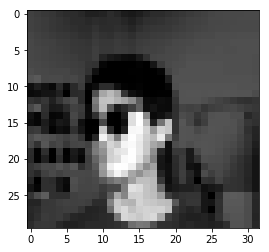

Classifier prediction is [ True] that the image is a sunglasses


In [9]:
indexSung = np.where(Y4=='sunglasses')[0]
# randomly pick an image
np.random.seed(42)
pick = indexSung[np.random.choice(indexSung.shape[0])]
sung4 = A4[pick,:]
# reshape into a matrix
sung4_image = sung4.reshape(30, 32)
plt.ion() 
plt.imshow(sung4_image, cmap=plt.cm.gray)
plt.show()

print('Classifier prediction is {0} that the image is a sunglasses'.format(bin_clf.predict([sung4])))

Calculate accuracy

In [10]:
Y4pred_train = bin_clf.predict(A4train)
print('Classifier accuracy on the training set is {0} '.format(accuracy_score(Y4train_sung, Y4pred_train)))

Y4pred_test = bin_clf.predict(A4test)
print('Classifier accuracy on the test set is {0} '.format(accuracy_score(Y4test_sung, Y4pred_test)))

Classifier accuracy on the training set is 1.0 
Classifier accuracy on the test set is 0.8951612903225806 


Calculate precision, recall and the f1 score; easy to crunch numbers ourselves but its built in. And the confusion matrix.

In [11]:
print('Classifier scores on training set: ')
print('Precision is {0} '.format(precision_score(Y4train_sung, Y4pred_train)))
print('Recall is {0} '.format(recall_score(Y4train_sung, Y4pred_train)))
print('F1 is {0} '.format(f1_score(Y4train_sung, Y4pred_train)))

print( 'And the confusion matrix: \n {0}'.format(confusion_matrix(Y4train_sung, Y4pred_train) ))

print()
print('Classifier scores on test set: ')
print('Precision is {0} '.format(precision_score(Y4test_sung, Y4pred_test)))
print('Recall is {0} '.format(recall_score(Y4test_sung, Y4pred_test)))
print('F1 is {0} '.format(f1_score(Y4test_sung, Y4pred_test)))

print( 'And the confusion matrix: \n {0}'.format(confusion_matrix(Y4test_sung, Y4pred_test) ))

Classifier scores on training set: 
Precision is 1.0 
Recall is 1.0 
F1 is 1.0 
And the confusion matrix: 
 [[252   0]
 [  0 248]]

Classifier scores on test set: 
Precision is 0.890625 
Recall is 0.9047619047619048 
F1 is 0.8976377952755906 
And the confusion matrix: 
 [[54  7]
 [ 6 57]]


D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear][LibLinear]

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

Text(0,0.5,'Count')

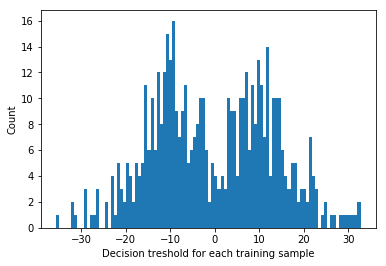

In [12]:
y_scores = cross_val_predict(bin_clf, A4train, Y4train_sung, cv=3, method="decision_function")
n, bins, patches = plt.hist(y_scores, 100)

plt.xlabel('Decision treshold for each training sample')
plt.ylabel('Count')

In [13]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [14]:
fpr, tpr, thresholds = roc_curve(Y4train_sung, y_scores)

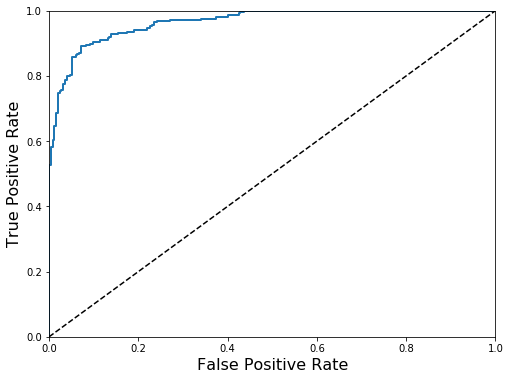

In [15]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

# Multiclass classifier

In [16]:
le = LabelEncoder()
le.fit(Y4[:,1])
Y4train_poses = le.transform(Y4train[:,1])
Y4test_poses = le.transform(Y4test[:,1])
print("Classes:", le.classes_)
print("First 10 train   : ", Y4train[:,1][1:10])
print("First 10 train enc: ", Y4train_poses[1:10])
print("First 10 test    : ", Y4test[:,1][1:10])
print("First 10 test enc: ", Y4test_poses[1:10])

Classes: ['left' 'right' 'straight' 'up']
First 10 train   :  ['up' 'up' 'straight' 'right' 'left' 'left' 'right' 'up' 'straight']
First 10 train enc:  [3 3 2 1 0 0 1 3 2]
First 10 test    :  ['straight' 'up' 'left' 'left' 'straight' 'up' 'right' 'right' 'right']
First 10 test enc:  [2 3 0 0 2 3 1 1 1]


In [17]:
mul_clf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs', verbose=True)
mul_clf.fit(A4train, Y4train_poses)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=True, warm_start=False)

In [18]:
Y4pred_train = mul_clf.predict(A4train)
print('Classifier accuracy on the training set is {0} '.format(accuracy_score(Y4train_poses, Y4pred_train)))

Y4pred_test = mul_clf.predict(A4test)
print('Classifier accuracy on the test set is {0} '.format(accuracy_score(Y4test_poses, Y4pred_test)))

Classifier accuracy on the training set is 1.0 
Classifier accuracy on the test set is 0.9354838709677419 


In [19]:
conf_mx_train = confusion_matrix(Y4train_poses, Y4pred_train)
conf_mx_test = confusion_matrix(Y4test_poses, Y4pred_test) 
print( 'The confusion matrix on train set: \n {0}'.format(conf_mx_train))
print( 'The confusion matrix on test set: \n {0}'.format(conf_mx_test))

The confusion matrix on train set: 
 [[127   0   0   0]
 [  0 126   0   0]
 [  0   0 127   0]
 [  0   0   0 120]]
The confusion matrix on test set: 
 [[29  0  1  0]
 [ 0 27  2  0]
 [ 0  0 28  1]
 [ 0  0  4 32]]


In [20]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

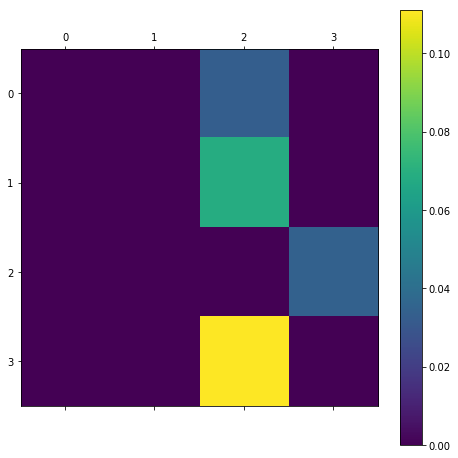

In [21]:
row_sums = conf_mx_test.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx_test / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

From the confusion matrix above, the ordering of the poses is \['left' 'right' 'straight' 'up'\]. The classifier has the most difficulty with the pose 'straight'. All poses 'left', 'right' and 'up' get mistaken for 'straight' at least once, where pose 'up' gets interpreted as 'straight' the most. We also see that the pose 'straight' gets interpreted as 'up' once as well.

# Expression Classiﬁction 

Try to zoom in on the mouth. Depending on the pose, zoom in on different rows and columns.

In [22]:
# try to just zoom in on the mouth

indexStraightTrain = np.where(Y1train=='straight')[0]
indexRightTrain = np.where(Y1train=='right')[0]
indexLeftTrain = np.where(Y1train=='left')[0]
indexUpTrain = np.where(Y1train=='up')[0]

indexStraightTest = np.where(Y1test=='straight')[0]
indexRightTest = np.where(Y1test=='right')[0]
indexLeftTest = np.where(Y1test=='left')[0]
indexUpTest = np.where(Y1test=='up')[0]

row1, row2 = 60, 90
col1, col2 = 30, 90

A1train_temp = A1train.reshape(len(A1train),120,128)
A1train_zoom = np.zeros((len(A1train), (row2-row1)*(col2-col1)))
for i, val in enumerate(A1train_temp):
    if i in indexStraightTrain:
        t = A1train_temp[i,row1:row2,col1:col2]
    elif i in indexRightTrain:
        t = A1train_temp[i,row1:row2,(col1-20):(col2-20)]
    elif i in indexLeftTrain:
        t = A1train_temp[i,row1:row2,(col1+20):(col2+20)]
    elif i in indexUpTrain:
        t = A1train_temp[i,(row1-15):(row2-15),col1:col2]
        
    t = t.reshape((row2-row1)*(col2-col1))
    A1train_zoom[i] = t

A1test_temp = A1test.reshape(len(A1test),120,128)
A1test_zoom = np.zeros((len(Y1test), (row2-row1)*(col2-col1)))
for i, val in enumerate(A1test_temp):
    if i in indexStraightTrain:
        t = A1test_temp[i,row1:row2,col1:col2]
    elif i in indexRightTrain:
        t = A1test_temp[i,row1:row2,(col1-20):(col2-20)]
    elif i in indexLeftTrain:
        t = A1test_temp[i,row1:row2,(col1+20):(col2+20)]
    elif i in indexUpTrain:
        t = A1test_temp[i,(row1-20):(row2-20),col1:col2]
        
    t = t.reshape((row2-row1)*(col2-col1))
    A1test_zoom[i] = t
    
le = LabelEncoder()
le.fit(Y1[:,2])
Y1train_exp = le.transform(Y1train[:,2])
Y1test_exp = le.transform(Y1test[:,2])
#print("# train set: ", len(Y1train_exp))
#print("# test set:", len(Y1test_exp))
print("Classes:", le.classes_)
print("First 10 train   : ", Y1train[:,2][1:10])
print("First 10 train enc: ", Y1train_exp[2:10])
print("First 10 test    : ", Y1test[:,2][1:10])
print("First 10 test enc: ", Y1test_exp[2:10])

Classes: ['angry' 'happy' 'neutral' 'sad']
First 10 train   :  ['neutral' 'angry' 'neutral' 'neutral' 'happy' 'happy' 'neutral' 'happy'
 'angry']
First 10 train enc:  [0 2 2 1 1 2 1 0]
First 10 test    :  ['angry' 'neutral' 'neutral' 'neutral' 'happy' 'angry' 'sad' 'angry' 'sad']
First 10 test enc:  [2 2 2 1 0 3 0 3]


Find images labeled angry, happy, neutral, sad.

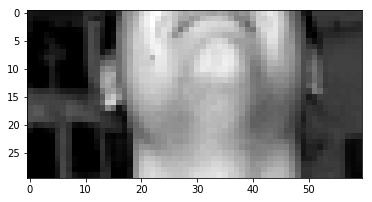

In [23]:
indexAngry = np.where(Y1train=='happy')[0]
# randomly pick an image
pick = indexAngry[np.random.choice(indexAngry.shape[0])]
angry4 = A1train_zoom[pick,:]
# reshape into a matrix
#angry4_image = angry4.reshape(120, 128)
angry4_image = angry4.reshape(row2-row1, col2-col1)
plt.ion() 
plt.imshow(angry4_image, cmap=plt.cm.gray)
plt.show()

### Try CNN algorithm

In [27]:
# Reference architecture design from
# https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

batch_size = 5
num_classes = 4
epochs = 50

# input image dimensions
img_rows, img_cols = 30, 60

x_train = A1train_zoom
x_test = A1test_zoom
# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(Y1train_exp, num_classes)
y_test = tensorflow.keras.utils.to_categorical(Y1test_exp, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (500, 30, 60, 1)
500 train samples
124 test samples
Train on 500 samples, validate on 124 samples
Epoch 1/50
500/500 [==============================] - 21s 43ms/step - loss: 1.4319 - acc: 0.2000 - val_loss: 1.3877 - val_acc: 0.2097
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 1.3976 - acc: 0.2500 - val_loss: 1.3897 - val_acc: 0.2258
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 1.3876 - acc: 0.2660 - val_loss: 1.4988 - val_acc: 0.2581
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 1.3826 - acc: 0.2700 - val_loss: 1.4028 - val_acc: 0.1613
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 1.3408 - acc: 0.3720 - val_loss: 1.4284 - val_acc: 0.2016
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 1.3194 - acc: 0.3680 - val_loss: 1.4454 - val_acc: 0.1935
Epoch 7/50
500/500 [==============================] - 1s 2ms/step - loss: 1.2708 - acc: 0.444

### Try several machine learning algorithms

In [28]:
names = [
         "KNeighbors",  
         "Random Forest", 
         "Neural Net", 
         "Linear Regression",
         "SGD Classifier",
         "NB"
    ]

classifiers = [
    KNeighborsClassifier(n_neighbors=4),
    RandomForestClassifier(n_estimators=100, random_state=9),
    OneVsOneClassifier(MLPClassifier()),
    OneVsOneClassifier(LogisticRegression()),
    OneVsOneClassifier(SGDClassifier(max_iter=1000, alpha=1, l1_ratio=1, random_state=4)),
    OneVsOneClassifier(GaussianNB())
]

In [29]:
for name, clf in zip(names, classifiers):
    clf.fit(A1train_zoom, Y1train_exp)
    ypred = clf.predict(A1train_zoom)
    ypred_test = clf.predict(A1test_zoom)

    print(name)
    print('Classifier accuracy on the train set is {0} '.format(accuracy_score(Y1train_exp, ypred)))
    print('Classifier accuracy on the test set is {0} '.format(accuracy_score(Y1test_exp, ypred_test)))    
    conf_mx_train = confusion_matrix(Y1train_exp, ypred)
    conf_mx_test = confusion_matrix(Y1test_exp, ypred_test) 
    print( 'The confusion matrix on train set: \n {0}'.format(conf_mx_train))
    print( 'The confusion matrix on test set: \n {0}'.format(conf_mx_test))
    print()

KNeighbors
Classifier accuracy on the train set is 0.422 
Classifier accuracy on the test set is 0.21774193548387097 
The confusion matrix on train set: 
 [[83 12  9 16]
 [50 50 12 15]
 [46 22 51 10]
 [58 19 20 27]]
The confusion matrix on test set: 
 [[15 13  2  5]
 [15  6  6  1]
 [ 8 12  3  6]
 [12  9  8  3]]

Random Forest
Classifier accuracy on the train set is 1.0 
Classifier accuracy on the test set is 0.1935483870967742 
The confusion matrix on train set: 
 [[120   0   0   0]
 [  0 127   0   0]
 [  0   0 129   0]
 [  0   0   0 124]]
The confusion matrix on test set: 
 [[ 7 19  4  5]
 [ 8 12  3  5]
 [ 9 15  2  3]
 [ 9 16  4  3]]

Neural Net
Classifier accuracy on the train set is 0.456 
Classifier accuracy on the test set is 0.2903225806451613 
The confusion matrix on train set: 
 [[84 10  7 19]
 [33 40 16 38]
 [14 15 56 44]
 [37 16 23 48]]
The confusion matrix on test set: 
 [[11  8  6 10]
 [ 7 10  3  8]
 [ 1 10  3 15]
 [10  7  3 12]]



D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

Linear Regression
Classifier accuracy on the train set is 1.0 
Classifier accuracy on the test set is 0.28225806451612906 
The confusion matrix on train set: 
 [[120   0   0   0]
 [  0 127   0   0]
 [  0   0 129   0]
 [  0   0   0 124]]
The confusion matrix on test set: 
 [[ 8  7 14  6]
 [ 2 11  7  8]
 [ 4 13  7  5]
 [ 5 11  7  9]]

SGD Classifier
Classifier accuracy on the train set is 1.0 
Classifier accuracy on the test set is 0.27419354838709675 
The confusion matrix on train set: 
 [[120   0   0   0]
 [  0 127   0   0]
 [  0   0 129   0]
 [  0   0   0 124]]
The confusion matrix on test set: 
 [[ 8  9  8 10]
 [ 4 13  5  6]
 [ 4 15  4  6]
 [ 4 13  6  9]]

NB
Classifier accuracy on the train set is 0.294 
Classifier accuracy on the test set is 0.21774193548387097 
The confusion matrix on train set: 
 [[73 16  3 28]
 [61 33  0 33]
 [64 22  5 38]
 [65 20  3 36]]
The confusion matrix on test set: 
 [[15 13  1  6]
 [13 11  0  4]
 [16 10  0  3]
 [12 19  0  1]]



From the results above, we find Logistic Regression classifier gives the best accuracy, with 100% accuracy on training and 28.23% on test. We consider the test results are better than random, but not better than classifying all images as one class... For example in our test set the expression 'angry' appears the most, in which there are 35 images labeled as 'angry', and classifying all images as 'angry' gives 28.23%. This task is similar to classifying poses given that one needs to classify them into 4 classes with similar number of training and test examples, where each class has roughly the same number of training and test examples, that is even distributed between 4 classes. The task is different to classifying poses because the head pose affects the classifier's accuracy to classify expressions. For example if the pose is 'up' and the person is smiling, the smile looks more like frown because the head tilts the smile down. It is straightforward to notice that if all the poses were 'straight', the classifier would have an easier time classifying the expressions. In addition whether there are sunglasses also affects the classifier's accuracy, since the expression around the eyes cannot be detected. This is why we focused on zooming in on the mouth, and found this improved accuracy on the test set, but not by more than about 8%.